# 准备工作

In [1]:
import dnois
import matplotlib.pyplot as plt
import torch
import torchvision

from e2e.model import ImagingSystem
from e2e.specification import parse_spec_file

In [2]:
torch.set_grad_enabled(False)
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 光学系统分析
## 创建光学系统模型

In [ ]:
design_file_path = 'design-files/lwir.py'
specification = parse_spec_file(design_file_path)
model = ImagingSystem.from_specification(specification)
model.to(dev)
o = model.o

In [ ]:
ckpt_path = None
if ckpt_path is not None:
    ckpt = torch.load(ckpt_path, weights_only=True)
    model.load_state_dict(ckpt['state_dict'])

In [3]:
model.c

Camera(
  (optics): CoaxialRayTracing(
    (surfaces): CoaxialSurfaceSequence(
      (0): Spherical(
        material=Ge, reflective=False,
        roc=inf
        (aperture): CircularAperture(radius=0.0085m)
        (context): CoaxialContext(distance=0.001m)
      )
      (1): Spherical(
        material=vacuum, reflective=False,
        roc=inf
        (aperture): CircularAperture(radius=0.0085m)
        (context): CoaxialContext(distance=0.002m)
      )
      (2): EvenAspherical(
        material=Ge, reflective=False,
        roc=0.13401m,
        conic=150,
        a1=0,a2=54400,a3=-9.325e+08,a4=7.281e+12
        (aperture): CircularAperture(radius=0.0105m)
        (context): CoaxialContext(distance=0.004m)
      )
      (3): EvenAspherical(
        material=vacuum, reflective=False,
        roc=inf,
        conic=0,
        a1=0,a2=68330,a3=-1.077e+09,a4=9.722e+12
        (aperture): CircularAperture(radius=0.0095m)
        (context): CoaxialContext(distance=0.003m)
      )
      

## 系统特征

In [4]:
def lfmt(x):
    return dnois.Length.fmt(x.item(), 'mm')


entr_pupil_r, entr_pupil_z = o.entr_pupil()
exit_pupil_r, exit_pupil_z = o.exit_pupil()
fl = o.focal_length2()
# 以下均默认为中心波长的值
print(f'Entrance pupil: radius={lfmt(entr_pupil_r)}, z={lfmt(entr_pupil_z)}')
print(f'Exit pupil: radius={lfmt(exit_pupil_r)}, z={lfmt(exit_pupil_z)}')
print(f'Focal length: {lfmt(fl)}')

Entrance pupil: radius=8.04857mm, z=6.64245mm
Exit pupil: radius=7.327mm, z=10mm
Focal length: 44.605mm


## 光路可视化

(<Figure size 1280x960 with 1 Axes>, <Axes: xlabel='$z/m$', ylabel='$y/m$'>)

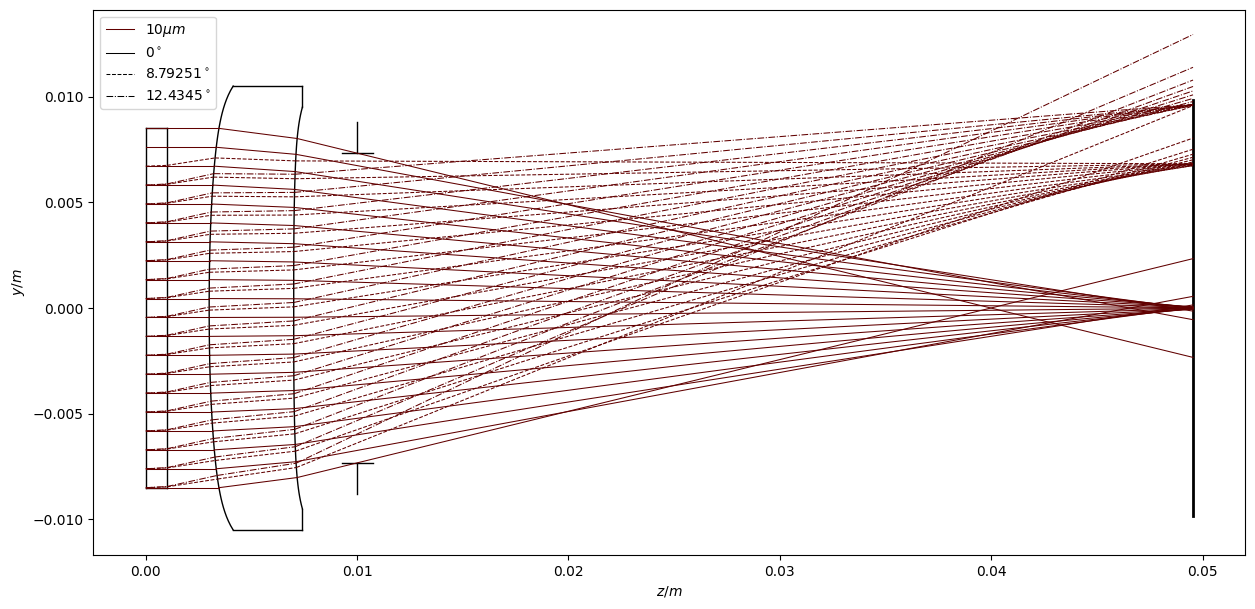

In [5]:
o.plot_cross_section(wl=o.wl[1])

## 点扩散函数

In [6]:
def vis_psf(psf, segments, vis_size):
    segments = (segments[0] + 1) // 2, (segments[1] + 1) // 2
    psf_max = psf.max()
    psf_vis = (psf / psf_max)
    fig, axs = plt.subplots(*segments, figsize=(12, 9))
    for i in range(segments[0]):
        for j in range(segments[1]):
            ax = axs[i, j]
            psf_seg = dnois.utils.resize(psf_vis[i, j], vis_size)
            if psf_seg.ndim == 3:
                psf_seg = psf_seg.permute(1, 2, 0)
            ax.imshow(psf_seg.cpu().numpy(), vmin=0, vmax=1)
            ax.set(xticks=[], yticks=[])

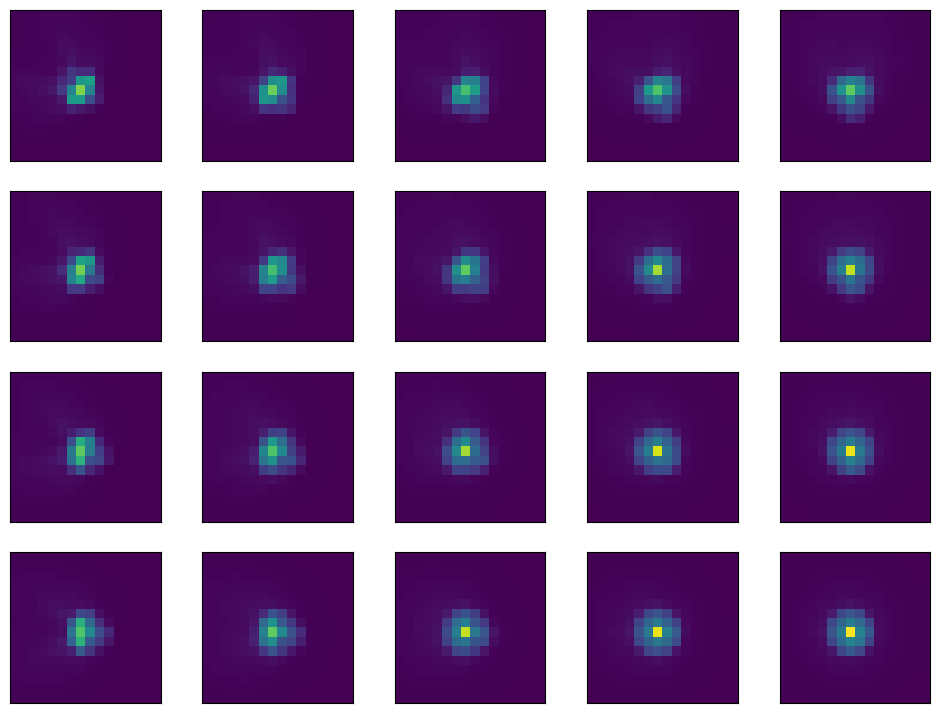

In [7]:
points = o.points_grid(o.segments, o.depth.squeeze().item())[:4, :5]
psf = o.psf(points, wl=o.wl[1])  #(NH, NW, Nwl, H, W)
vis_psf(psf, o.segments, 16)

## 成像模拟

In [10]:
image = torchvision.io.read_image('asset/test.jpg')
image = image.to(device=dev, dtype=o.dtype) / 255
image = dnois.utils.resize(image, o.sensor.resolution)
image = image.unsqueeze(0)
pred, captured = model(image)

Text(0.5, 1.0, 'Restored')

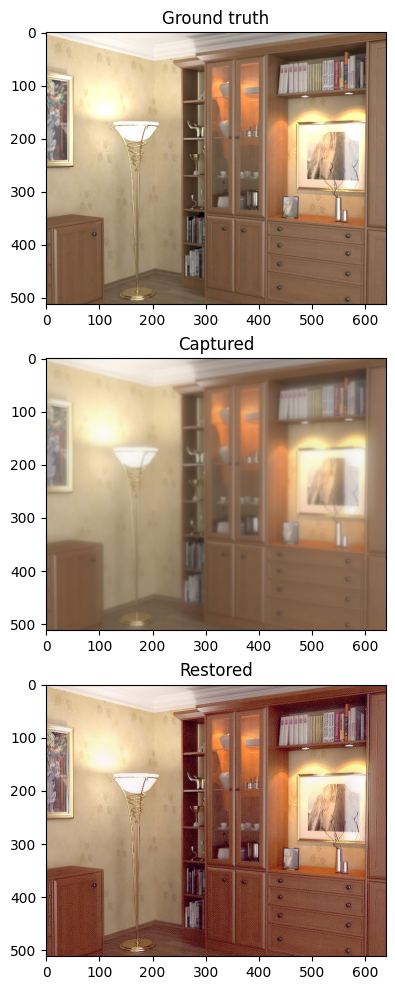

In [12]:
fig, axs = plt.subplots(3, 1, figsize=(6, 12))
axs[0].imshow(image.squeeze(0).permute(1, 2, 0).cpu().numpy())
axs[0].set_title('Ground truth')
axs[1].imshow(captured.squeeze(0).permute(1, 2, 0).cpu().numpy())
axs[1].set_title('Captured')
axs[2].imshow(pred.squeeze(0).permute(1, 2, 0).cpu().numpy())
axs[2].set_title('Restored')

# 文件导出

In [ ]:
o.surfaces.save_json('structure/exported.json')